In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

incubation_df = pd.read_csv("data-out/incubation_df.csv")

In [2]:
#get "longest incubation values" from single sentences and collect all info in a dataframe
incubation_table_docs = []
longest = ["range", "ranging", "ranged", "longest", "up to", "maximum"]

for i in range(len(incubation_df)):
    for compound_sentence in re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', incubation_df["full_text"].values[i]):
        for simple_sentence in compound_sentence.split(", "):
            for m in longest:
                if m in simple_sentence and "incubation" in simple_sentence and "interquartile" not in simple_sentence:
                    incubation_day = re.findall(r'(\d{1,2}(\.\d{1,2})? day[s]?)', simple_sentence)
                    if len(incubation_day) == 1:
                        num = incubation_day[0][0].split(" ")
                        incubation_table_docs.append([float(num[0]), incubation_day, simple_sentence, compound_sentence, incubation_df["title"].values[i], incubation_df["sha"].values[i], incubation_df["publish_time"].values[i]])
                    if len(incubation_day) > 1:
                        num_list = []
                        for day in incubation_day:
                            num = day[0].split(" ")[0]
                            num_list.append(float(num))
                        max_num = max(num_list)
                        incubation_table_docs.append([max_num,
                                                    incubation_day,
                                                    simple_sentence,
                                                    compound_sentence,
                                                    incubation_df["title"].values[i],
                                                    incubation_df["sha"].values[i],
                                                    incubation_df["publish_time"].values[i],
                                                    incubation_df["journal"].values[i],
                                                    incubation_df["url"].values[i]])

incubation_table = pd.DataFrame(incubation_table_docs, columns=["incubation_day",
                                                                "days",
                                                                "simple_sentence",
                                                                "compound_sentence",
                                                                "paper_title",
                                                                "sha",
                                                                "publish_time",
                                                                "journal",
                                                                "url"])
incubation_table.head()

,incubation_day,days,simple_sentence,compound_sentence,paper_title,sha,publish_time,journal,url
0,7.0,"[(7 days, )]",we estimated that the length of isolation in t...,we estimated that the length of isolation in t...,Global versus focused isolation during the SAR...,08a40e31fde744729050ab037f80aa67c7d1053f,2020-04-01,None,None
1,55.0,"[(55 days, )]",the longest incubation period was 55 days.,the longest incubation period was 55 days.,Clinical features and outcomes of 197 adult di...,0c85befc7b4ab7e702e8fbadd9e07f6dbd870559,2020-03-30,None,None
2,10.0,"[(10 days, )]",the incubation period of our cases was in a ra...,"consistent to previous reports, the incubation...",Prevalence and clinical features of 2019 novel...,0eee9760aee0ca2fdf8d1d215c3689d5f8d84df5,2020-02-27,None,None
3,11.1,"[(11.1 days, .1)]",the incubation period ranges from 2.1 to 11.1 ...,the incubation period ranges from 2.1 to 11.1 ...,Title: The incubation period of 2019-nCoV infe...,12fac9aedb1a09a3922a3c084ce4723708e463d6,2020-01-28,None,None
4,15.5,"[(15.5 days, .5)]",the incubation period ranging from 2.4 to 15.5...,although the lognormal distribution provides t...,Title: The incubation period of 2019-nCoV infe...,12fac9aedb1a09a3922a3c084ce4723708e463d6,2020-01-28,None,None


In [3]:
# skip duplicates by paper_id, compound sentence
incubation_table.drop_duplicates(subset="compound_sentence", inplace=True)
incubation_table.drop_duplicates(subset="sha", inplace=True)
incubation_table.shape

(54, 9)

In [4]:
incubation_table.to_csv("data-out/incubation_table_longest.csv", index=False, header=True)

In [5]:
#go through the csv file, then pick sentences with incorrect resutts
sentences_to_delete = ["\nbest estimate (used in figure 2 ) plausible range (used in figure 3 )\n\nmean incubation period 5.5 days sensitivity: 4.5 or 6.5 clinical data: 83% fever",
                        "we estimated that the length of isolation in the high risk population will decrease from two weeks to an average of 7 days which is within the range of the average incubation period (6) (7) (8) .",
                        "an influenza outbreak can be declared over if no new cases occur within 8 days following the onset of symptoms in the last resident case (8 days is the sum of the usual infectious period [5 days] plus maximum incubation period [3days])."]

update_dict = {"in which the incubation period is exponentially distributed with mean l in the range of 3 -6 days and the infectious period is also exponentially distributed with mean z in the range of 2 to 7 days.": 6.0,
                    "the median incubation period was 3.0 days (range": 24.0,
                    "reported that the estimated mean incubation period of sars-cov-2 infection was 3.0 days (range" : 24.0,
                    "the study indicated the median incubation period to be 3.0 days (range": 24.0,
                    "9 the range of the incubation period for 2019-ncov is estimated to be 2-14 days": 24.0}

sentences_to_update = list(update_dict.keys())

no_of_error = len(sentences_to_delete) + len(sentences_to_update)
error_percentage = no_of_error/len(incubation_table["incubation_day"].values)*100
print("error %: ", error_percentage)

error %:  14.814814814814813


In [6]:
#drop non-related results
incubation_table = incubation_table[~incubation_table["simple_sentence"].isin(sentences_to_delete)]
incubation_table.shape

(51, 9)

In [7]:
#update correct results
to_update = incubation_table.copy()[incubation_table["simple_sentence"].isin(sentences_to_update)]
to_update["incubation_day"] = to_update["simple_sentence"].map(update_dict)
incubation_table = incubation_table[~incubation_table["simple_sentence"].isin(sentences_to_update)]
incubation_table = pd.concat([incubation_table, to_update])
incubation_table.shape

(51, 9)

In [8]:
incubation_table.to_csv("data-out/incubation_table_longest_corrected.csv", index=False, header=True)

In [9]:
#get incubation mean values
incubation_longest = incubation_table["incubation_day"].values
print(incubation_longest)
print(incubation_table.groupby("incubation_day")["compound_sentence"].count().sort_values(ascending=False))

[55.  10.  11.1 11.1 23.  32.  10.  14.   6.  14.  14.  14.  15.  33.
 23.  11.3 14.  14.  24.  14.  20.  14.  24.  14.  14.   8.  14.  24.
 10.  14.  14.  14.  14.  14.  14.  14.  13.  14.  14.  13.  20.   9.
 14.  22.  14.  24.   6.  24.  24.  24.  24. ]
incubation_day
14.0    22
24.0     8
10.0     3
23.0     2
20.0     2
13.0     2
11.1     2
6.0      2
55.0     1
33.0     1
32.0     1
22.0     1
15.0     1
11.3     1
9.0      1
8.0      1
Name: compound_sentence, dtype: int64


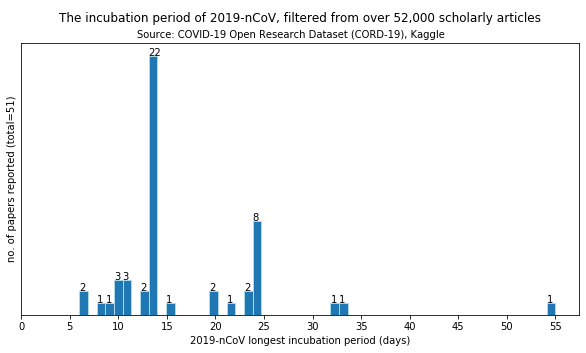

In [10]:
#plot results
fig, ax = plt.subplots(figsize=[10,5])
bins = int(max(incubation_longest))
arr = plt.hist(incubation_longest, ec="lightblue", bins=bins)
for i in range(bins):
    if arr[0][i] != 0:
        plt.text(arr[1][i],arr[0][i],str(int(arr[0][i])))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks(np.arange(0,bins+1,5))
plt.ylabel(f"no. of papers reported (total={len(incubation_longest)})")
plt.xlabel("2019-nCoV longest incubation period (days)")
plt.title("The incubation period of 2019-nCoV, filtered from over 52,000 scholarly articles\n")
plt.suptitle("\n\nSource: COVID-19 Open Research Dataset (CORD-19), Kaggle\n\n", fontsize=10)
plt.show()